# Task 2

## Problem
Implement a circuit that returns |01> and |10> with equal probability.

Requirements :
- The circuit should consist only of CNOTs, RXs and RYs. 
- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
- You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
- Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

Bonus question:
How to make sure you produce state |01> + |10> and not |01> - |10> ?


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem" data-toc-modified-id="Problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem</a></span></li><li><span><a href="#Basic-task" data-toc-modified-id="Basic-task-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Basic task</a></span><ul class="toc-item"><li><span><a href="#Wild-Guess!" data-toc-modified-id="Wild-Guess!-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Wild Guess!</a></span></li><li><span><a href="#Defining-the-variational-circuit" data-toc-modified-id="Defining-the-variational-circuit-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Defining the variational circuit</a></span></li><li><span><a href="#Defining-the-cost-function" data-toc-modified-id="Defining-the-cost-function-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Defining the cost function</a></span></li><li><span><a href="#Putting-it-all-together" data-toc-modified-id="Putting-it-all-together-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Putting it all together</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Analysis</a></span></li></ul></li><li><span><a href="#Comparing-different-optimizers" data-toc-modified-id="Comparing-different-optimizers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparing different optimizers</a></span></li><li><span><a href="#Visualizing-cost-function" data-toc-modified-id="Visualizing-cost-function-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualizing cost function</a></span></li><li><span><a href="#Bonus-Question" data-toc-modified-id="Bonus-Question-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bonus Question</a></span><ul class="toc-item"><li><span><a href="#Redifining-the-circuit" data-toc-modified-id="Redifining-the-circuit-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Redifining the circuit</a></span></li><li><span><a href="#Redifining-the-cost-function" data-toc-modified-id="Redifining-the-cost-function-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Redifining the cost function</a></span></li><li><span><a href="#Putting-it-all-together" data-toc-modified-id="Putting-it-all-together-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Putting it all together</a></span></li></ul></li></ul></div>

In [1]:
from qiskit import QuantumCircuit, IBMQ
from qiskit.circuit import Parameter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.device import basic_device_noise_model
from qiskit import Aer
from qiskit.visualization import plot_histogram
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
pi = np.pi

In [2]:
#Load the IBM account
provider = IBMQ.load_account()
ibmq_16_melbourne = provider.get_backend('ibmq_16_melbourne')
device_properties = ibmq_16_melbourne.properties()

noise_model = basic_device_noise_model(device_properties)

/home/nikhil/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
/home/nikhil/.local/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/basic_device_model.py:111: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  warnings.warn(


## Basic task

Let's first make a basic variational circuit template with two qubits and just enough gates to produce $\vert01\rangle$ and $\vert10\rangle$ with half probability each. Here the proposal is that only two Ry gates on each qubit and a CNOT gate is needed to get to the target state. The circuit of which should look like the one shown below.

In [3]:
param0 = Parameter('theta')
param1 = Parameter('phi')

qc = QuantumCircuit(2)
qc.ry(param0, 0)
qc.ry(param1, 1)
qc.cx(0,1)
qc.draw()

┌───────────┐     
q_0: ┤ RY(theta) ├──■──
     └┬─────────┬┘┌─┴─┐
q_1: ─┤ RY(phi) ├─┤ X ├
      └─────────┘ └───┘

### Wild Guess!

Now its shown below that the above proposal is not just a wild guess by showing the maths happening behind the circuit and thus proving that the above circuit should be able to solve the problem.

Lets see how the RY gate operation looks like on the first qubit $\vert0\rangle$ (initial state).

$$ RY_{\theta}\vert0\rangle = \begin{bmatrix} cos(\theta/2) & -sin(\theta/2) \\ sin(\theta/2) & cos(\theta/2)\end{bmatrix}\begin{bmatrix} 1 \\ 0 \end{bmatrix} = \begin{bmatrix} cos(\theta/2) \\ sin(\theta/2) \end{bmatrix}$$

Similarly for the second state we get,

$$ RY_{\phi}\vert0\rangle = \begin{bmatrix} cos(\phi/2) & -sin(\phi/2) \\ sin(\phi/2) & cos(\phi/2)\end{bmatrix}\begin{bmatrix} 1 \\ 0 \end{bmatrix} = \begin{bmatrix} cos(\phi/2) \\ sin(\phi/2) \end{bmatrix}$$

To write the state of a composite system, tensor product of the individual states are taken which can be written as,

$$ RY_{\theta}\vert0\rangle \otimes RY_{\phi}\vert0\rangle = \begin{bmatrix} cos(\theta/2) \\ sin(\theta/2) \end{bmatrix} \otimes \begin{bmatrix} cos(\phi/2) \\ sin(\phi/2) \end{bmatrix} = \begin{bmatrix}  cos(\theta/2)cos(\phi/2) \\ cos(\theta/2)sin(\phi/2) \\sin(\theta/2)cos(\phi/2) \\ sin(\theta/2)sin(\phi/2) \end{bmatrix}$$

Now if we apply the CNOT gate with the first qubit as control and second as target, we are done.

$$ CNOT(RY_{\theta}\vert0\rangle \otimes RY_{\phi}\vert0\rangle) = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\0 & 0 & 0 & 1 \\0 & 0 & 1 & 0 \end{bmatrix}\begin{bmatrix}  cos(\theta/2)cos(\phi/2) \\ cos(\theta/2)sin(\phi/2) \\sin(\theta/2)cos(\phi/2) \\ sin(\theta/2)sin(\phi/2) \end{bmatrix} = \begin{bmatrix}  cos(\theta/2)cos(\phi/2) \\ cos(\theta/2)sin(\phi/2) \\ sin(\theta/2)sin(\phi/2) \\sin(\theta/2)cos(\phi/2) \end{bmatrix}$$ 

If we check what the final state actually is by putting the value $\theta = \pi/2$ and $\phi = \pi$, the state simplifies to,

$$\begin{bmatrix}  0 \\ \frac{1}{\sqrt2} \\ \frac{1}{\sqrt2} \\ 0 \end{bmatrix} = \frac{1}{\sqrt2}\begin{bmatrix}  0 \\ 1 \\ 0 \\ 0 \end{bmatrix} + \frac{1}{\sqrt2} \begin{bmatrix}  0 \\ 0 \\ 1 \\ 0 \end{bmatrix} = \frac{1}{\sqrt2}\vert01\rangle + \frac{1}{\sqrt2}\vert10\rangle $$

And by squaring the coefficients, its clear that we got what we were looking for. By this calculation, its proved that only two RY and one CNOT gate is enough for our problem. It's also seen that if our optimization works perfectly the value of $\theta$ and $\phi$ should converge to $\pi/2$ and $\pi$ respectively.



### Defining the variational circuit
The above circuit is imported from qiskit to pennylane and measurements are added to the circuit.

In [20]:
#device with noise model from ibmq_16_melbourne
dev1 = qml.device("qiskit.aer", wires=2, noise_model = noise_model, shots=1024, analytic=False)

param0 = Parameter('theta')
param1 = Parameter('phi')

qc = QuantumCircuit(2)
qc.ry(param0, 0)
qc.ry(param1, 1)
qc.cx(0,1)
qc = qml.from_qiskit(qc)

@qml.qnode(dev1)
def circuit(x):
    qc({param0 : x[0], param1: x[1]})
    return qml.probs(wires = [0,1])

### Defining the cost function

The outcome of our measurement is going to be the probability of the possible two qubits states, namely $\vert00\rangle$, $\vert01\rangle$, $\vert01\rangle$, $\vert01\rangle$. Among these we want the probability of $\vert01\rangle$ and $\vert01\rangle$ half each. So we define the cost function as,

$$J = (P_{00})^2 + (0.5 - P_{01})^2 + (0.5 - P_{10})^2 + (P_{11})^2$$

Here when P$_{01}^2$ and P$_{00}^2$ is 0.5 each, the cost function is minimum, zero. And so our problem reduces to finding a variational parameters for which cost of the circuit is lowest.

In [21]:
def cost_fun(params):
    prob = circuit(params)
    p00, p01, p10, p11 = prob
    cost = (p00)**2 + (0.5 - p01)**2 + (0.5 - p10)**2 + (p11)**2
    return cost

### Putting it all together

Once variational circuit and cost function is defined, the final thing to do is optimization of the variational parameters. Here the gradient descent optimizer from pennylane is used for the same. 

In [22]:
def circuit_opt(shot, iteration, opt):
    #randomly initialized initial parameters
    print(shot, 'measurements per iteration:')
    params = [0,0]
    dev1.shots = shot
    optimizer = opt
    costs = []
    for i in range(iteration):
        cost = cost_fun(params)
        params = optimizer.step(cost_fun, params)
        costs.append(cost)
    print("The optimal parameter is ", params)
    print("The final cost is ", costs[-1])
    print()
    return params, costs

In [8]:
#Lets call the above function with a list of measurements to be taken per iteration and iterations per optimization
shots = [1,10,100,1000]
iteration = 75
#Using pennylane gradient descent optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.2)
#Store the lists of cost convergence for each number of shots
cost_shot = []
#Store the final parameters value after the optimization
final_params = []

for shot in shots:
    final_param, costs = circuit_opt(shot, iteration, opt)
    final_params.append(final_param)
    cost_shot.append(costs)    
    

1 measurements per iteration:
The optimal parameter is  [2.0, 3.1]
The final cost is  0.5

10 measurements per iteration:
The optimal parameter is  [-1.3840000000000006, -2.8439999999999976]
The final cost is  0.060000000000000005

100 measurements per iteration:
The optimal parameter is  [-1.6026200000000008, 2.791980000000001]
The final cost is  0.028600000000000007

1000 measurements per iteration:
The optimal parameter is  [-1.5856675999999996, 2.7337756000000017]
The final cost is  0.011889999999999998



### Analysis
The circuit has been executed and variational parameters should have converged to the value which would give lowest cost and thus equal probability of getting $\vert01\rangle$ and $\vert10\rangle$.

Let's first see how the cost function has varied with number of iterations for different numbers of measurements.

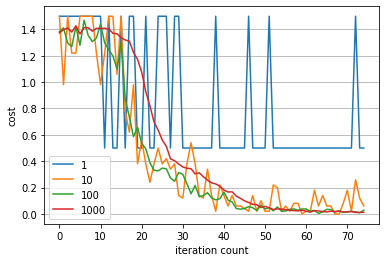

In [9]:
labels = [str(x) for x in shots]
for i in range(len(shots)):
    plt.plot(range(iteration),cost_shot[i], label = labels[i])
plt.xlabel('iteration count') 
plt.ylabel('cost') 
plt.grid(which = 'both', axis = 'y')
plt.legend()
plt.show()

It's seen that the rate of convergence does not have a  very strong relation with the number of measurements being done per iteration in the above case. The convergence with 1000 measurements was slowest to decrease initially, though it was more uniform than the lower mesurements. Do note that with single measurements being done the cost has only two level: '1.5' and '0.5'. It can be explained by the fact that if a single measurement is done, the outcome being $\vert01\rangle$ or $\vert10\rangle$ the other 3 probabilities is directly zero and so the cost function is 0.5 or in the other case it is 1.5.

At the end of optimization for each measurement rounds the values of variational parameters when fed in the variational circuit should give us equal probability for $\vert01\rangle$ or $\vert10\rangle$. Lets check the same by plotting histograms. Here 1024 measurements is being done for better comparison, as the optimization is already done with varying measurments.

In [23]:
def plot_graph(params):
    prob = circuit(params)
    result = {'00': prob[0], '01': prob[1], '10': prob[2], '11': prob[3] }
    return plot_histogram(result, figsize=(6, 4))

images = []
for i in range(len(shots)):
    images.append(plot_graph(final_params[i]))
    print(shots[i], "measurements per iteration used for circuit optimization:")
    display(images[i])


TypeError: object of type 'int' has no len()

## Comparing different optimizers

The optimization done above was using basic gradient descent. There are many more advanced optimization algorithm that can make our variational parameters converge faster. Lets now compare the convergence of some different optimizers for this the number of shots per measurements will be kept fixed.

1. Gradient descent optimizer
2. Momentum gradient descent optimizer
3. Adaptive gradient descent optimizer

In [24]:
#Lets call the above function with a list of measurements to be taken per iteration and iterations per optimization
shots = 100
iteration = 50
#Store the lists of cost convergence for each number of shots
cost_opt = []
#Store the final parameters value after the optimization
final_opt = []
optimizers = []

optimizers.append(qml.GradientDescentOptimizer(stepsize=0.2))
optimizers.append(qml.MomentumOptimizer(stepsize=0.2, momentum = 0.8))
optimizers.append(qml.AdagradOptimizer(stepsize=0.2, eps=1e-08))

labels = ["Basic GD", "Momentum GD", "Adagrad"]

for i in range(len(optimizers)):
    print(labels[i], "optimizer")
    final_param, costs = circuit_opt(shots, iteration,optimizers[i])
    final_opt.append(final_param)
    cost_opt.append(costs)


Basic GD optimizer
100 measurements per iteration:
The optimal parameter is  [-1.51372, -2.51996]
The final cost is  0.029800000000000007

Momentum GD optimizer
100 measurements per iteration:
The optimal parameter is  [1.6018278726825639, 3.2496963053062387]
The final cost is  0.010000000000000002

Adagrad optimizer
100 measurements per iteration:
The optimal parameter is  [-1.5838589315997598, -2.2964613743801885]
The final cost is  0.065



In [ ]:
for i in range(len(labels)):
    plt.plot(range(iteration),cost_opt[i], label = labels[i])
plt.xlabel('iteration count') 
plt.ylabel('cost') 
plt.grid(axis = 'y')
plt.legend()
plt.show()

## Visualizing cost function

Let's go back to the final state vector we derived previously and see how many solution does it have. 

$$\begin{bmatrix}  cos(\theta/2)cos(\phi/2) \\ cos(\theta/2)sin(\phi/2) \\ sin(\theta/2)sin(\phi/2) \\sin(\theta/2)cos(\phi/2) \end{bmatrix} = cos(\theta/2)cos(\phi/2)\vert00\rangle + cos(\theta/2)sin(\phi/2)\vert01\rangle + sin(\theta/2)sin(\phi/2)\vert10\rangle + sin(\theta/2)cos(\phi/2)\vert11\rangle$$

And the way cost function is defined, the theoretical definition of cost function can be written as,
$$J(\theta, \phi) = \{(cos(\theta/2)cos(\phi/2))^2\}^2 + \{0.5 - (cos(\theta/2)sin(\phi/2))^2\}^2 + \{0.5 - (sin(\theta/2)sin(\phi/2))^2\}^2 + \{(sin(\theta/2)cos(\phi/2))^2\}^2$$

It was required to make the coefficients of $\vert00\rangle$ and $\vert11\rangle$ to be 0 so that there is no probability for those states to appear in final measurement, and accordingly it was required for the coefficient of $\vert01\rangle$ and $\vert10\rangle$ to be equal to $\frac{1}{2}$ when squared individually.

To make the first coefficient zero, either of $cos(\theta/2$) or $cos(\phi/2$) needs to be zero and the former being zero would also make the coefficient of $\vert01\rangle$ zero, which is not what is required. So, cos($\phi/2$) = 0 which gives $\phi = \pi$ or $-\pi$. This would also make the coefficients of $\vert11\rangle$ zero.

The coefficients of $\vert01\rangle$ and $\vert10\rangle$ needs to be made $\frac{1}{\sqrt2}$ so that their square gives $\frac{1}{2}$. $\phi$ = $\pi$ or $-\pi$ gives sin($\phi/2$) = 1. And so the value of $cos^2(\theta/2)$ should be $\frac{1}{2}$. Which on solving gives $\theta = \pi/2$ or $-\pi/2$.

So to conclude the possible solutions of the cost function are: $[(\pi/2, \pi), (-\pi/2, \pi), (\pi/2, -\pi), (-\pi/2, -\pi)]$. Let's try to visualize this by plotting the surface of cost function.

In [ ]:
def cost_theory(theta,phi):
    p00 = (np.cos(theta/2)*np.cos(phi/2))**2
    p01 = (np.cos(theta/2)*np.sin(phi/2))**2
    p10 = (np.sin(theta/2)*np.sin(phi/2))**2
    p11 = (np.sin(theta/2)*np.cos(phi/2))**2
    cost = (p00)**2 + (0.5 - p01)**2 + (0.5 - p10)**2 + (p11)**2
    return cost

x = np.arange(-4,4,0.1)
y = np.arange(-4,4,0.1)
X,Y = np.meshgrid(x,y)
Z = cost_theory(X,Y)

In [ ]:
%matplotlib notebook
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');

Of the four minima in the above surface, two $[(\pi/2, \pi)$ and $(\pi/2, -\pi)]$ corresponds to $\frac{1}{\sqrt2}(\vert01\rangle + \vert10\rangle)$ and the other two $[(-\pi/2, \pi)$ and $(-\pi/2, -\pi)]$ corresponds to the $\frac{1}{\sqrt2}(\vert01\rangle - \vert10\rangle)$. This takes us to the bonus question of the task. 

##  Bonus Question

The general state capable of giving half probability of $\vert01\rangle$ and $\vert10\rangle$ each is,

$$\vert\Psi\rangle = \frac{1}{\sqrt2}\vert01\rangle + \frac{1}{\sqrt2}e^{i\alpha}\vert10\rangle$$

Since the solution provided above did not used any Rx rotation it was seen in the final state that none of the coefficients had imaginary part. Thus the above equation reduced to,

$$\vert\Psi\rangle = \frac{1}{\sqrt2}\vert01\rangle \pm \frac{1}{\sqrt2}\vert10\rangle$$

These two states can be distinguished easily by doing a bell basis measurement which is applying the CNOT gate that takes the first qubit to $\vert1\rangle$ with certainity, followed by a hadamard that takes superposition of first qubit to computational basis and then final measurement. Since the task restricts to use only Rx and Ry gates, an appropiate angle for such rotation might also do the job.

The hadamard gate maps $\frac{1}{\sqrt2}(\vert0\rangle+\vert1\rangle) \rightarrow \vert0\rangle$ and $\frac{1}{\sqrt2}(\vert0\rangle-\vert1\rangle) \rightarrow \vert1\rangle$ if instead of hadamard Ry rotation by $\pi/2$ is used it would map $\frac{1}{\sqrt2}(\vert0\rangle+\vert1\rangle) \rightarrow \vert1\rangle$ and $\frac{1}{\sqrt2}(\vert0\rangle-\vert1\rangle) \rightarrow \vert0\rangle$. Though they are different, they can be used interchangeably to distinguish the two states. 

To conclude, if after the variational circuit a CNOT gate with second qubit as target and Ry gate on first qubit with $\pi/2$ rotation is added the states prepared in $\frac{1}{\sqrt2}\vert01\rangle + \frac{1}{\sqrt2}\vert10\rangle$ would give $\vert11\rangle$ with full probability and the one prepared in $\frac{1}{\sqrt2}\vert01\rangle - \frac{1}{\sqrt2}\vert10\rangle$ would give $\vert01\rangle$ with full proability.

### Redifining the circuit

As proposed above, the variational part of the circuit will now be followed by the CNOT gate and a $\pi/2$ Ry rotation. This part will kind of mimic the bell state measurement and will ensure that the optimized parameters in variational parts produce the target state. Note that this circuit itself does not produce the state, and its only role is to give us the parameters.

In [ ]:
param0 = Parameter('theta')
param1 = Parameter('phi')

qcb = QuantumCircuit(2)
qcb.ry(param0, 0)
qcb.ry(param1, 1)
qcb.cx(0,1)
qcb.barrier()
qcb.cx(0,1)
qcb.ry(pi/2, 0)
qcb.draw()

The above circuit will now be imported to pennylane with noise model.

In [ ]:
#device with noise model from ibmq_16_melbourne
dev1 = qml.device("qiskit.aer", wires=2, noise_model = noise_model, shots=1024, analytic=False)

qcb = qml.from_qiskit(qcb)

@qml.qnode(dev1)
def circuit_bonus(x):
    qcb({param0 : x[0], param1: x[1]})
    return qml.probs(wires = [0,1])

### Redifining the cost function

The above circuit would give $\vert11\rangle$ with full probability when the parameters are optimized to give the variational part $\frac{1}{\sqrt2}(\vert01\rangle + \vert10\rangle)$. And so the cost function needs to be redifined to give low output for the same. The cost function would now be defined as,

$$J = (P_{00})^2 + (0.5 - P_{01})^2 + (0.5 - P_{10})^2 + (P_{11})^2$$


In [ ]:
def cost_fun_bonus(params):
    prob = circuit_bonus(params)
    p00, p01, p10, p11 = prob
    cost = (p00)**2 + (p01)**2 + (p10)**2 + (1 - p11)**2
    return cost

### Putting it all together
The above variational circuit and cost function is now put together with the pennylane gradient descent optimizer.

In [ ]:
def circuit_opt_bonus(shots, iteration, opt):
    #randomly initialized initial parameters
    params = np.random.randn(2)
    dev1.shots = shot
    optimizer = opt
    costs = []
    for i in range(iteration):
        cost = cost_fun_bonus(params)
        params = optimizer.step(cost_fun_bonus, params)
        costs.append(cost)
    print(params)
    return params, costs

The optimization is done again for different number of shots per iteration and final parameters are noted.

In [ ]:
#Lets call the above function with a list of measurements to be taken per iteration and iterations per optimization
shots = [10,100,1000]
iteration = 75
#Using pennylane gradient descent optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.2)
#Store the lists of cost convergence for each number of shots
cost_shot = []
#Store the final parameters value after the optimization
final_params = []

for shot in shots:
    final_param, costs = circuit_opt_bonus(shot, iteration, opt)
    final_params.append(final_param)
    cost_shot.append(costs)    

In [ ]:
labels = [str(x) for x in shots]
for i in range(len(shots)):
    plt.plot(range(iteration),cost_shot[i], label = labels[i])
plt.xlabel('iteration count') 
plt.ylabel('cost') 
plt.grid(which = 'both', axis = 'y')
plt.legend()
plt.show()

In [ ]:
def plot_graph(params):
    prob = circuit(params)
    result = {'00': prob[0], '01': prob[1], '10': prob[2], '11': prob[3] }
    return plot_histogram(result, figsize=(6, 4))

images = []
for i in range(len(shots)):
    images.append(plot_graph(final_params[i]))
    print(shots[i], "measurements per iteration used for circuit optimization:")
    display(images[i])
